### Install and import packages

In [1]:
# Import packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_palette("tab10")

import random as rnd
import numpy as np
rnd.seed(0)
np.random.seed(0)

import scipy.stats as stats
import bayes_logistic

from utils import *

### Set parameters

In [2]:
# Set parameters
# data_x parameters
num_data = 2
num_data_half = num_data // 2
num_feats = 2

# num_samples 
num_samples = 1000

# weights prior distribution parameters
weights_prior_params = [
    [0.0, 0.0], [[1.0, 0.0], [0.0, 1.0]]]

# init sigma used in numerical optimization for laplace approximation
laplace_num_iters = 1000

### Generate data_x

In [3]:
# Generate data_x
# data_x = stats.uniform.rvs(0, 1, size=(num_data, num_feats), random_state=12345)
data_x = np.array([[0, 1], [1, 0]])
print(data_x)
print(data_x.shape)

[[0 1]
 [1 0]]
(2, 2)


### Sample weights, generate sample y from sample weights and visualize data

### Generate prior and posterior samples

Generate two set of prior samples A and B

$$
\begin{align*}
    & A = \{ \theta_i \}_{i=1}^N, \; \theta_i \sim p(\theta) \\
    & B = \{ \theta_i \}_{i=1}^N, \; \theta_i \sim p(\theta)
\end{align*}
$$

Generate a set of posterior from prior samples A

Notes: 
- $x$ is fixed and generated from the above procedure. Only $y_i$ is generated from $\theta_i$.

$$
\begin{align*}
    & C' = \{ \theta_i' \}_{i=1}^N, \\
    & \theta_i' \sim p(\theta|x, y_i), \\
    & y_i \sim p(y_i|x, \theta_i), \; \theta_i \in A
\end{align*}
$$

In [11]:
def sample_laplace_approx(X, y, weights_prior_params, laplace_num_iters):
    
    # note:
    # init params (mu and Hessian) for laplace approximation of posterior
    # are set to be the same as params of prior
    
    w_map, h_map = bayes_logistic.fit_bayes_logistic(
        y = y.squeeze(-1),
        X = X, 
        wprior = np.array(weights_prior_params[0]), 
        H = np.linalg.inv(np.array(weights_prior_params[1])),
        weights = None,
        solver = "Newton-CG",
        bounds = None,
        maxiter = laplace_num_iters
    )
    cov_map = np.linalg.inv(h_map)
    sample_w = stats.multivariate_normal.rvs(w_map, cov_map)
    
    return sample_w

In [22]:
### Generate prior and posterior samples

# weights' prior distribution
weights_prior_dist_a = stats.multivariate_normal(
    weights_prior_params[0], weights_prior_params[1], seed=1)
weights_prior_dist_b = stats.multivariate_normal(
    weights_prior_params[0], weights_prior_params[1], seed=11)


samples_a_weights_prior = []
samples_b_weights_prior = []
samples_a_weights_posterior = []
num_bootstraps = 5
for i in range(num_samples):
    # sample two set of weights' priors 
    sample_a_weights_prior = weights_prior_dist_a.rvs(1)[None,:]
    sample_b_weights_prior = weights_prior_dist_b.rvs(1)[None,:]
    samples_a_weights_prior.append(sample_a_weights_prior)
    samples_b_weights_prior.append(sample_b_weights_prior)
    # print(sample_a_weights_prior.shape)
    # print(sample_b_weights_prior.shape)
    
    sample_a_weights_posterior = sample_a_weights_prior
    sample_a_weights_posterior_bootstraps = []
    for _ in range(num_bootstraps):
        # generate sample y_i from theta_i in A
        # print()
        # print(data_x.shape)
        # print(sample_a_weights_prior.shape)
        sample_a_logit = 1.0 / (1 + np.exp(-np.matmul(data_x, sample_a_weights_posterior.T)))
        sample_a_y = stats.bernoulli.rvs(sample_a_logit)
        # print(sample_a_y.shape)
        # stop    
    
        # sample weights' posterior from laplace approximation
        sample_a_weights_posterior = sample_laplace_approx(
            data_x, sample_a_y, weights_prior_params, laplace_num_iters)
        sample_a_weights_posterior = sample_a_weights_posterior.reshape(1, num_feats)
        sample_a_weights_posterior_bootstraps.append(sample_a_weights_posterior)
        
    samples_a_weights_posterior.append(sample_a_weights_posterior)    

samples_a_weights_prior = np.vstack(samples_a_weights_prior)
samples_b_weights_prior = np.vstack(samples_b_weights_prior)
samples_a_weights_posterior = np.vstack(samples_a_weights_posterior)
print(samples_a_weights_prior.shape)
# print(samples_b_weights_prior)
# print(samples_a_weights_posterior)

(1000, 2)


### Visualize the generated prior and posterior samples

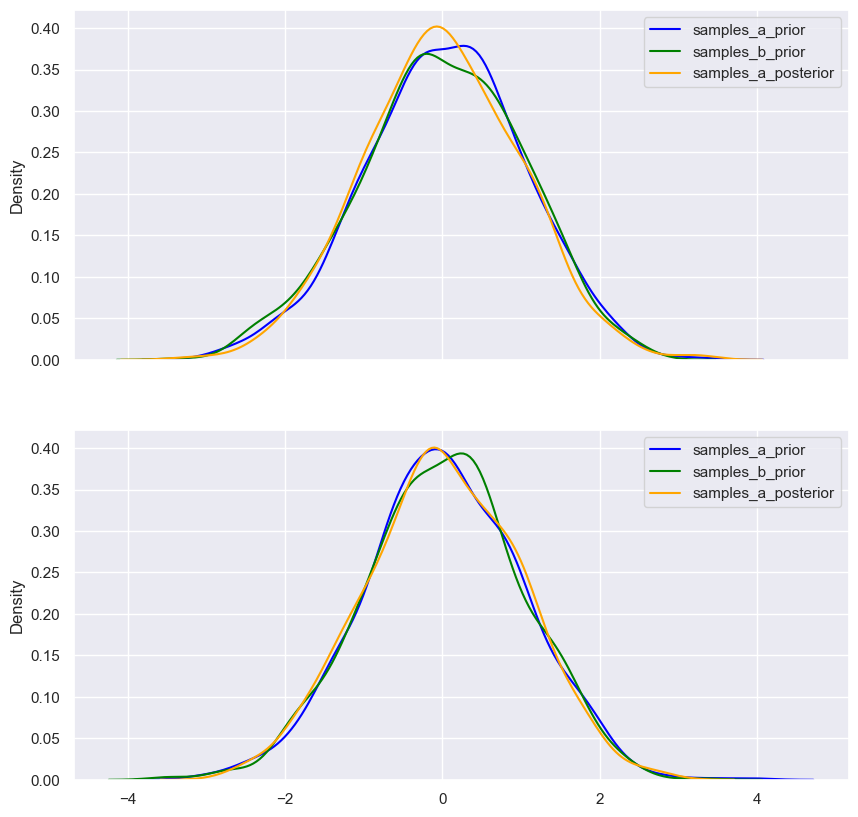

In [23]:
# Visualize the generated prior and posterior samples, individual features
nrows = 2
fig, axes = plt.subplots(nrows=nrows, ncols=1, sharex=True, sharey=True, figsize=(10,10))
axes = axes.flatten()

for i in range(nrows):
    sns.kdeplot(samples_a_weights_prior[:,i], fill=False, color="blue", label="samples_a_prior", ax=axes[i])
    sns.kdeplot(samples_b_weights_prior[:,i], fill=False, color="green", label="samples_b_prior", ax=axes[i])
    sns.kdeplot(samples_a_weights_posterior[:,i], fill=False, color="orange", label="samples_a_posterior", ax=axes[i])
    axes[i].legend()
plt.show()

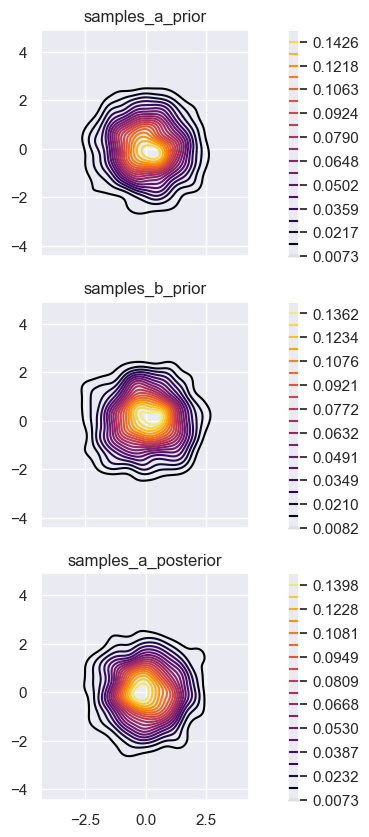

In [24]:
# Visualize the generated prior and posterior samples, pair of features
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(10,10))
axes = axes.flatten()

sns.kdeplot(x=samples_a_weights_prior[:,0], y=samples_a_weights_prior[:,1], n_levels=20, 
            cmap="inferno", fill=False, cbar=True, ax=axes[0])

sns.kdeplot(x=samples_b_weights_prior[:,0], y=samples_b_weights_prior[:,1], n_levels=20, 
            cmap="inferno", fill=False, cbar=True, ax=axes[1])

sns.kdeplot(x=samples_a_weights_posterior[:,0], y=samples_a_weights_posterior[:,1], n_levels=20, 
            cmap="inferno", fill=False, cbar=True, ax=axes[2])
axes[0].set_aspect(aspect="equal")
axes[1].set_aspect(aspect="equal")
axes[2].set_aspect(aspect="equal")
axes[0].set_title("samples_a_prior")
axes[1].set_title("samples_b_prior")
axes[2].set_title("samples_a_posterior")
plt.show()

### Measure the differences between the prior and samples

* Kernelized two sample test: maximum mean distance with RBF kernel
* Wasserstein distance of two samples
* Difference between the standard deviations (from true mean) of two samples

In [7]:
# Maximum mean distance with RBF kernel
mmd_rbf_prior_a_prior_b = compute_mmd_rbf(samples_a_weights_prior, samples_b_weights_prior)
mmd_rbf_posterior_a_prior_b = compute_mmd_rbf(samples_a_weights_posterior, samples_b_weights_prior)
print(f"MMD between prior a and prior b: {mmd_rbf_prior_a_prior_b:0.5f}")
print(f"MMD between posterior a and prior b: {mmd_rbf_posterior_a_prior_b:0.5f}")

MMD between prior a and prior b: 0.00219
MMD between posterior a and prior b: 0.00727


In [8]:
# Wasserstein distance with RBF kernel
wd_prior_a_prior_b = compute_wasserstein_distance(samples_a_weights_prior, samples_b_weights_prior)
wd_posterior_a_prior_b = compute_wasserstein_distance(samples_a_weights_posterior, samples_b_weights_prior)
print(f"Wasserstein distance between prior a and prior b: {wd_prior_a_prior_b:0.5f}")
print(f"Wasserstein distance between posterior a and prior b: {wd_posterior_a_prior_b:0.5f}")

Wasserstein distance between prior a and prior b: 0.97323
Wasserstein distance between posterior a and prior b: 3.38059


In [9]:
# Difference between the standard deviations (from true mean) of two samples
diff_std_prior_a_prior_b = compute_diff_std(samples_a_weights_prior, samples_b_weights_prior, weights_prior_params[0])
diff_std_posterior_a_prior_b = compute_diff_std(samples_a_weights_posterior, samples_b_weights_prior, weights_prior_params[0])
print(f"Difference standard deviations between between prior a and prior b: {diff_std_prior_a_prior_b:0.5f}")
print(f"Difference standard deviations between posterior a and prior b: {diff_std_posterior_a_prior_b:0.5f}")

Difference standard deviations between between prior a and prior b: 0.05072
Difference standard deviations between posterior a and prior b: 3.82631
